## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

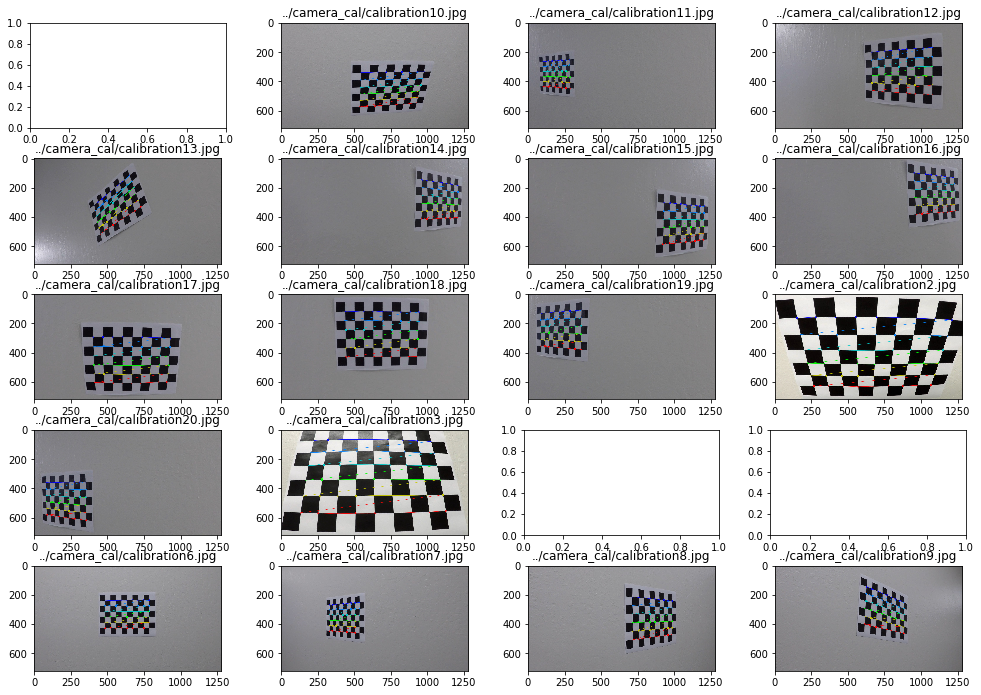

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

f, axs = plt.subplots((len(images)-1)//4+1, 4, figsize=(13, 10))
f.tight_layout()

# Step through the list and search for chessboard corners
for index, fname in enumerate(images):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axs.flat[index].imshow(img)
        axs.flat[index].set_title(fname)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Calibrate camera and undistort chessboard images

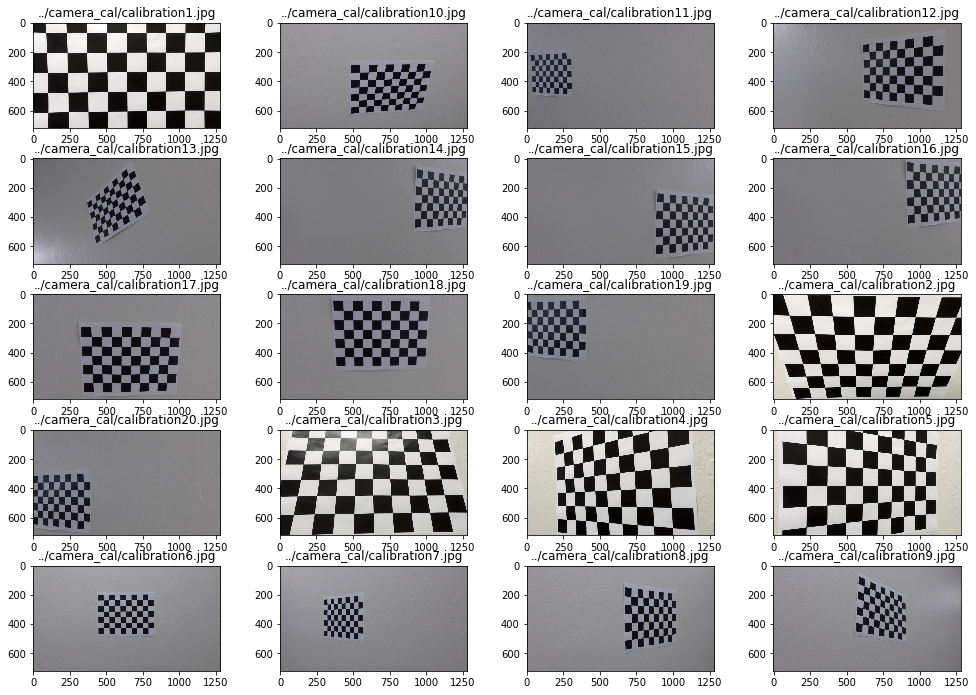

In [2]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

f, axs = plt.subplots((len(images)-1)//4+1, 4, figsize=(13, 10))
f.tight_layout()

# Step through the list and search for chessboard corners
for index, fname in enumerate(images):
    img = mpimg.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    axs.flat[index].imshow(dst)
    axs.flat[index].set_title(fname)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Undistort test images

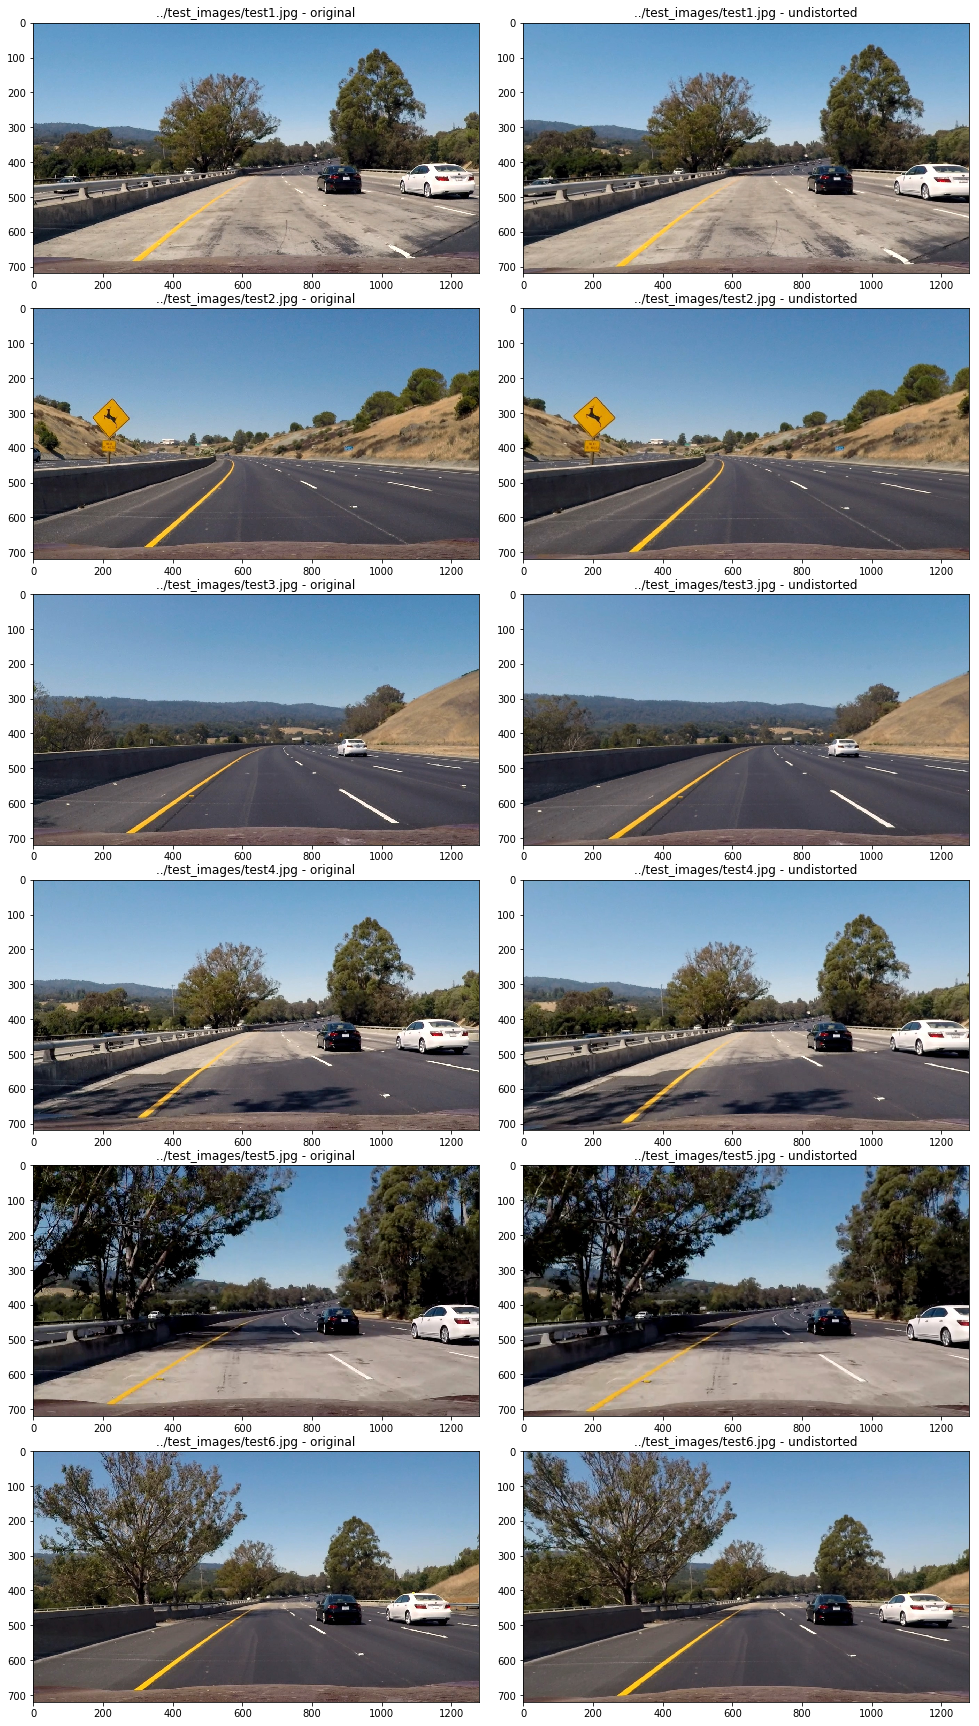

In [3]:
# Make a list of test images
images = glob.glob('../test_images/test*.jpg')

f, axs = plt.subplots(len(images), 2, figsize=(13, 26))
f.tight_layout()

# Step through the list and search for chessboard corners
for index, fname in enumerate(images):
    img = mpimg.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    axs.flat[index*2].imshow(img)
    axs.flat[index*2].set_title('{} - original'.format(fname))
    axs.flat[index*2+1].imshow(dst)
    axs.flat[index*2+1].set_title('{} - undistorted'.format(fname))

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Get binary images after color transforms and gradients

In [4]:
def get_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return color_binary, combined_binary

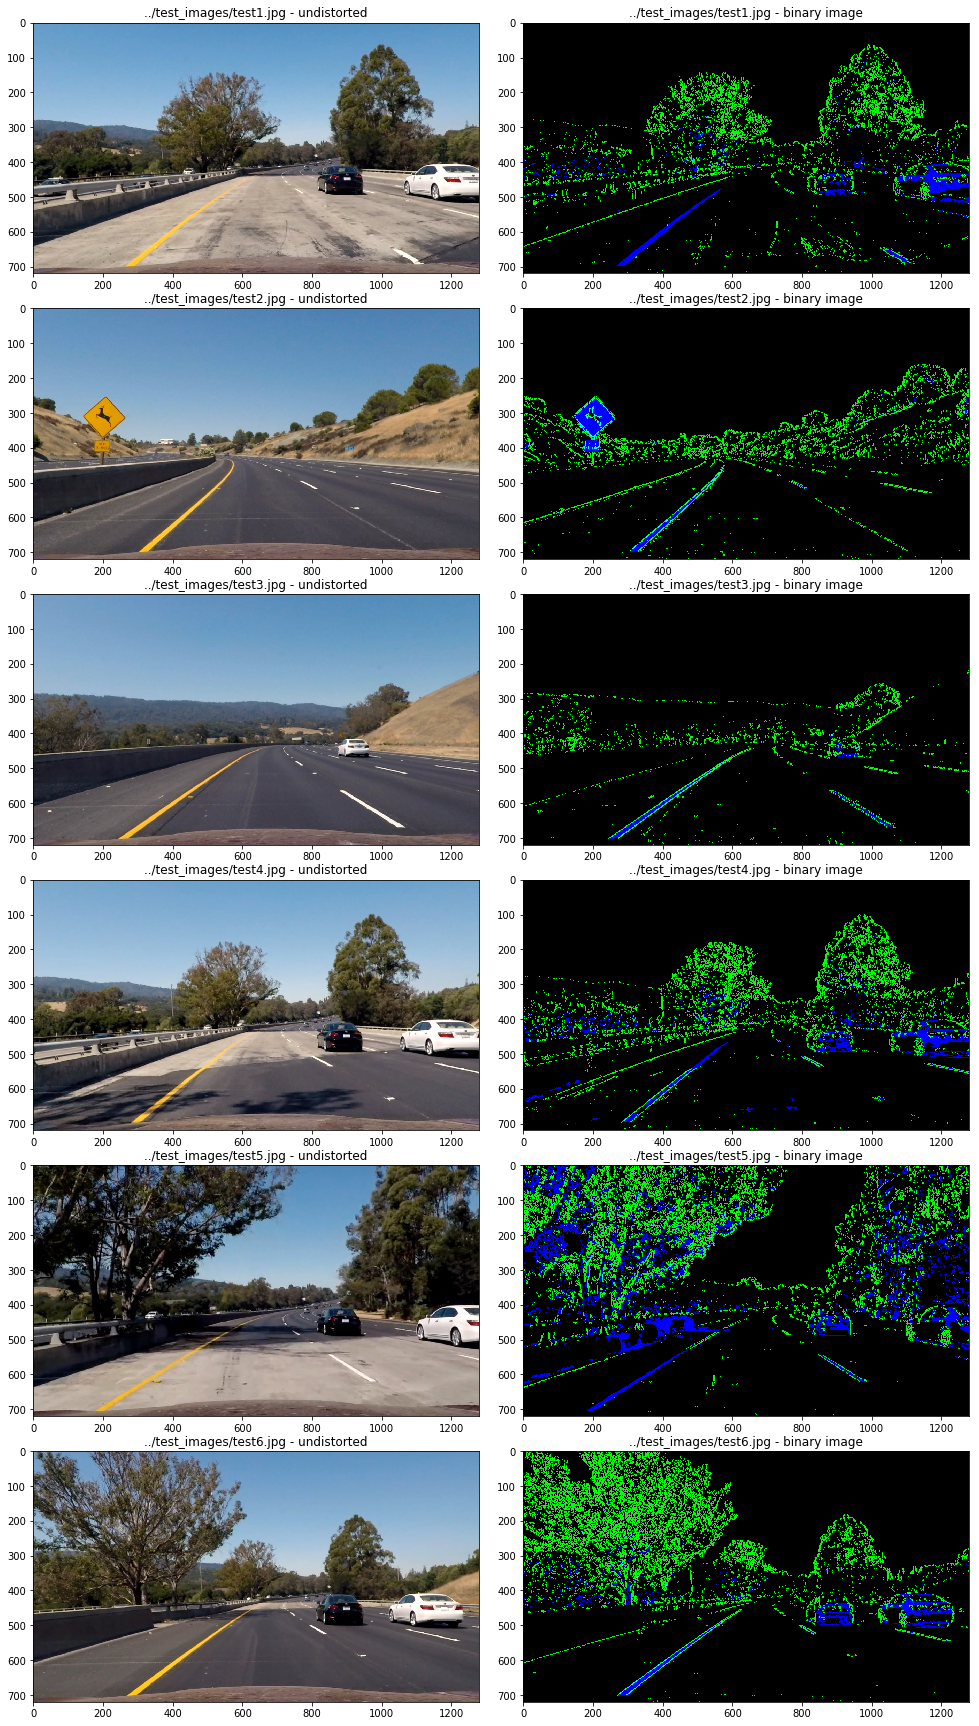

In [5]:
# Make a list of test images
images = glob.glob('../test_images/test*.jpg')

f, axs = plt.subplots(len(images), 2, figsize=(13, 26))
f.tight_layout()

# Step through the list and search for chessboard corners
for index, fname in enumerate(images):
    img = mpimg.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    color_binary, combined_binary = get_binary(dst)
    axs.flat[index*2].imshow(dst)
    axs.flat[index*2].set_title('{} - undistorted'.format(fname))
    axs.flat[index*2+1].imshow(color_binary)
    axs.flat[index*2+1].set_title('{} - binary image'.format(fname))

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply Perspective Transform

In [6]:
# Get perspective transform matrix
img = mpimg.imread('../test_images/test1.jpg')
img_size = (img.shape[1], img.shape[0])
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
     [((img_size[0] / 6) - 10), img_size[1]],
     [(img_size[0] * 5 / 6) + 60, img_size[1]],
     [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
     [(img_size[0] / 4), img_size[1]],
     [(img_size[0] * 3 / 4), img_size[1]],
     [(img_size[0] * 3 / 4), 0]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

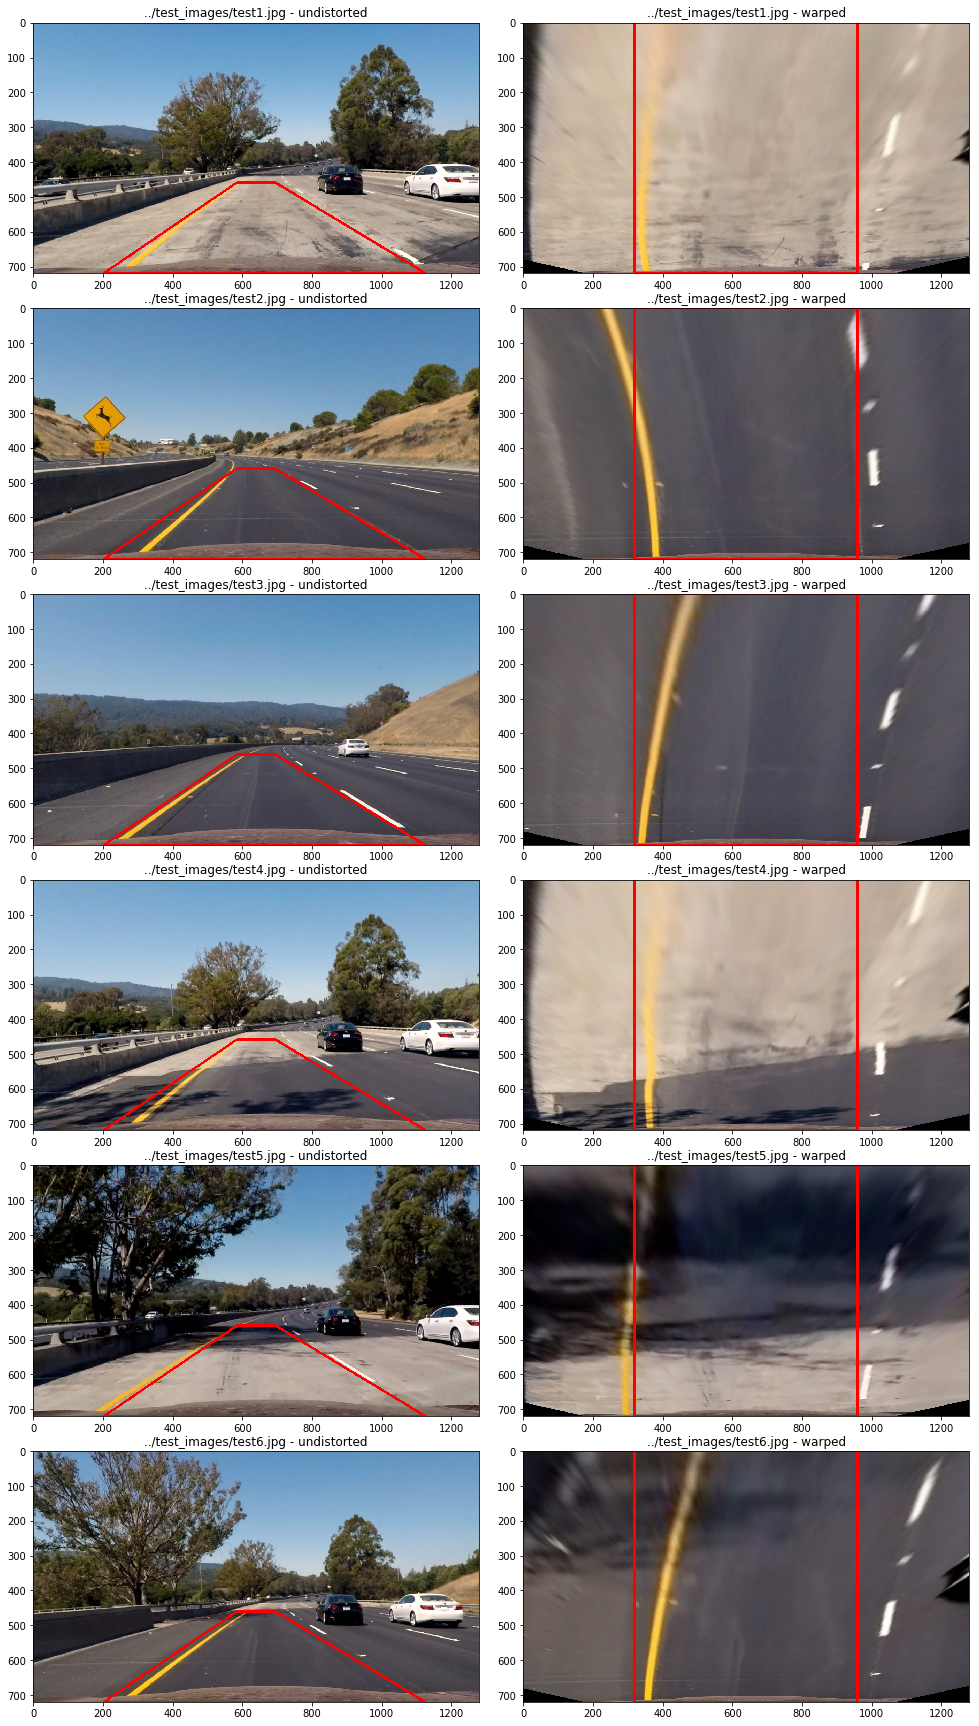

In [7]:
# Apply perspective transform to test images

# Make a list of test images
images = glob.glob('../test_images/test*.jpg')

f, axs = plt.subplots(len(images), 2, figsize=(13, 26))
f.tight_layout()

# Step through the list and search for chessboard corners
for index, fname in enumerate(images):
    img = mpimg.imread(fname)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    result = cv2.warpPerspective(undistorted, M, img_size, flags=cv2.INTER_LINEAR)
    src_pts = src.astype(int).reshape((-1,1,2))
    dst_pts = dst.astype(int).reshape((-1,1,2))
    cv2.polylines(undistorted, [src_pts], True, (255, 0, 0), thickness = 5)
    cv2.polylines(result, [dst_pts], True, (255, 0, 0), thickness = 5)
    axs.flat[index*2].imshow(undistorted)
    axs.flat[index*2].set_title('{} - undistorted'.format(fname))
    axs.flat[index*2+1].imshow(result)
    axs.flat[index*2+1].set_title('{} - warped'.format(fname))

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Find window centroid

In [8]:
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def draw_centroids(warped):
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    print(window_centroids)
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    return output


[(340.0, 994.0), (328.0, 913.0), (333.0, 1012.0), (338.0, 912.0), (343.0, 1011.0), (346.0, 1062.0), (351.0, 962.0), (251.0, 1061.0), (151.0, 1146.0)]
[(377.0, 979.0), (374.0, 979.0), (371.0, 1006.0), (356.0, 1004.0), (341.0, 1001.0), (323.0, 991.0), (305.0, 964.0), (280.0, 955.0), (259.0, 962.0)]
[(354.0, 985.0), (358.0, 990.0), (366.0, 1013.0), (379.0, 913.0), (394.0, 1012.0), (410.0, 1066.0), (426.0, 1105.0), (446.0, 1125.0), (470.0, 1141.0)]
[(368.0, 1017.0), (365.0, 1009.0), (373.0, 1024.0), (355.0, 1021.0), (352.0, 927.0), (362.0, 827.0), (373.0, 727.0), (365.0, 627.0), (265.0, 527.0)]
[(296.0, 981.0), (296.0, 981.0), (299.0, 1000.0), (305.0, 1009.0), (309.0, 1041.0), (318.0, 1053.0), (412.0, 969.0), (352.0, 1068.0), (375.0, 1129.0)]
[(369.0, 1012.0), (368.0, 1006.0), (379.0, 1040.0), (397.0, 1052.0), (412.0, 1079.0), (433.0, 1099.0), (449.0, 1121.0), (471.0, 1157.0), (491.0, 1179.0)]


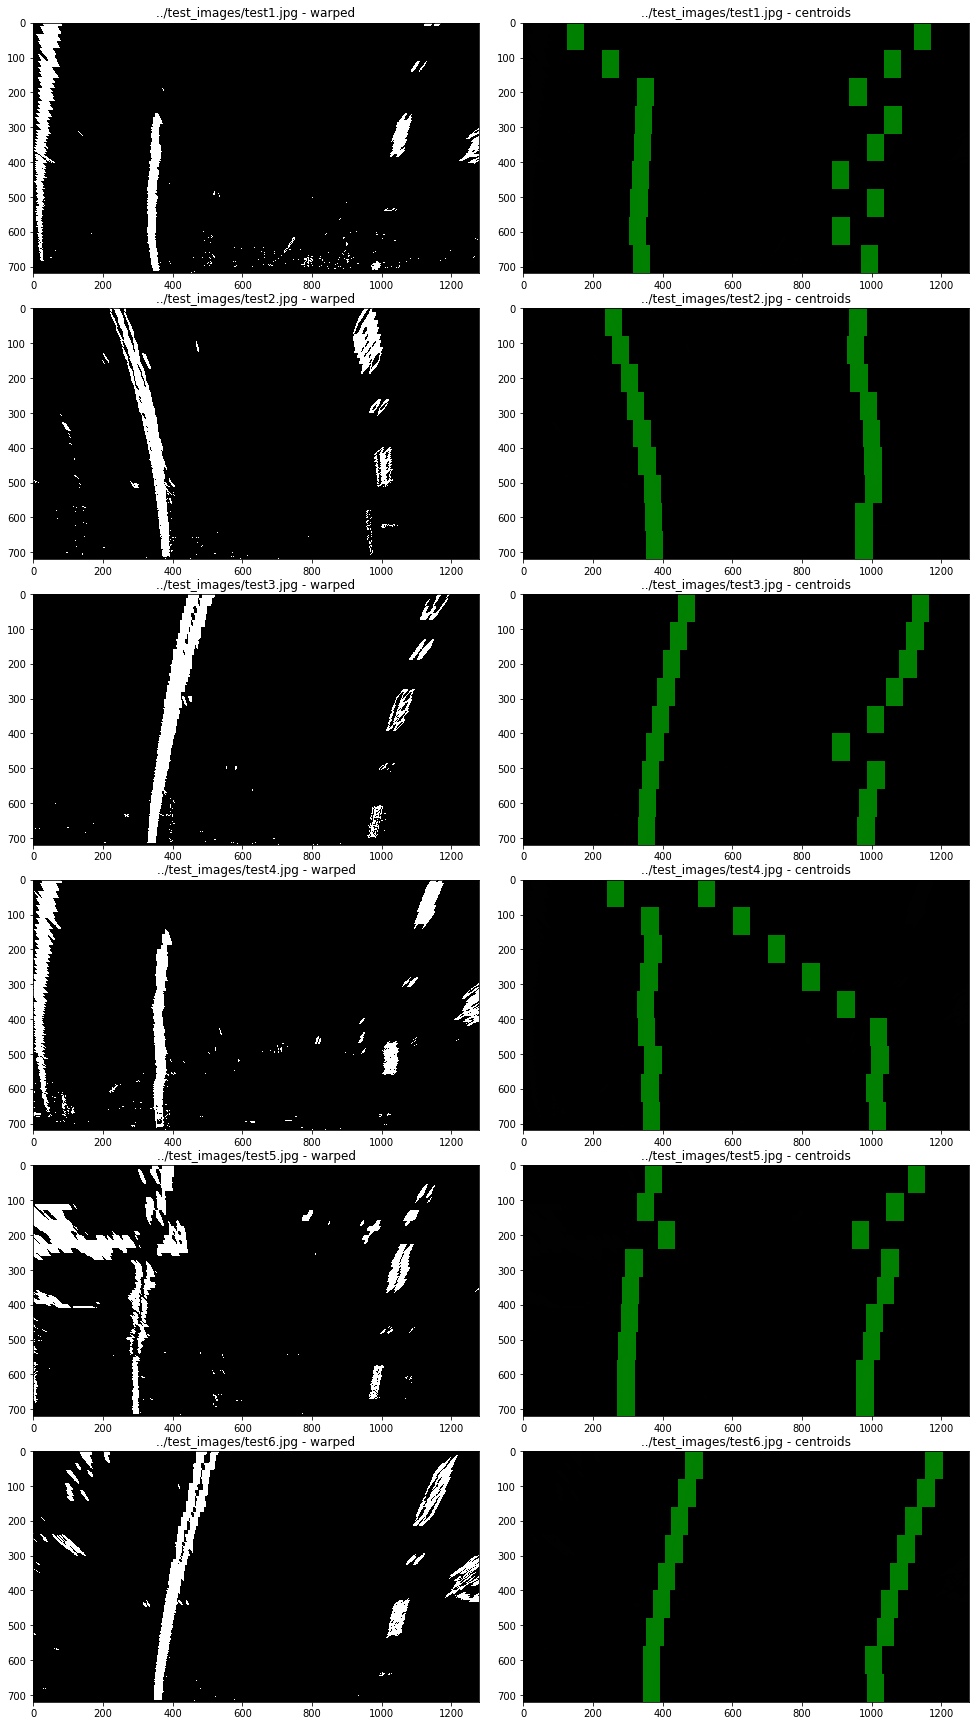

In [9]:
# Make a list of test images
images = glob.glob('../test_images/test*.jpg')

f, axs = plt.subplots(len(images), 2, figsize=(13, 26))
f.tight_layout()

# Step through the list and search for chessboard corners
for index, fname in enumerate(images):
    img = mpimg.imread(fname)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    color_binary, combined_binary = get_binary(undistorted)
    warped = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)
    centroids = draw_centroids(warped)
  
    axs.flat[index*2].imshow(warped, cmap="gray")
    axs.flat[index*2].set_title('{} - warped'.format(fname))
    axs.flat[index*2+1].imshow(centroids)
    axs.flat[index*2+1].set_title('{} - centroids'.format(fname))

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [10]:
nwindows = 9
window_width = 50 
margin = 100 # How much to slide left and right for searching

def find_lane_lines(binary_warped):
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    # Set height of windows
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    out_img[np.int_(ploty), np.clip(np.int_(left_fitx), 0, 1279)] = [255, 255, 0]
    out_img[np.int_(ploty), np.clip(np.int_(right_fitx), 0, 1279)] = [255, 255, 0]

    # Measure curvature
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(out_img, "Left: {:.0f}m, Right: {:.0f}m".format(left_curverad, right_curverad),(20,50), font, 1,(0,255,255),3,cv2.LINE_AA)
    
    return out_img

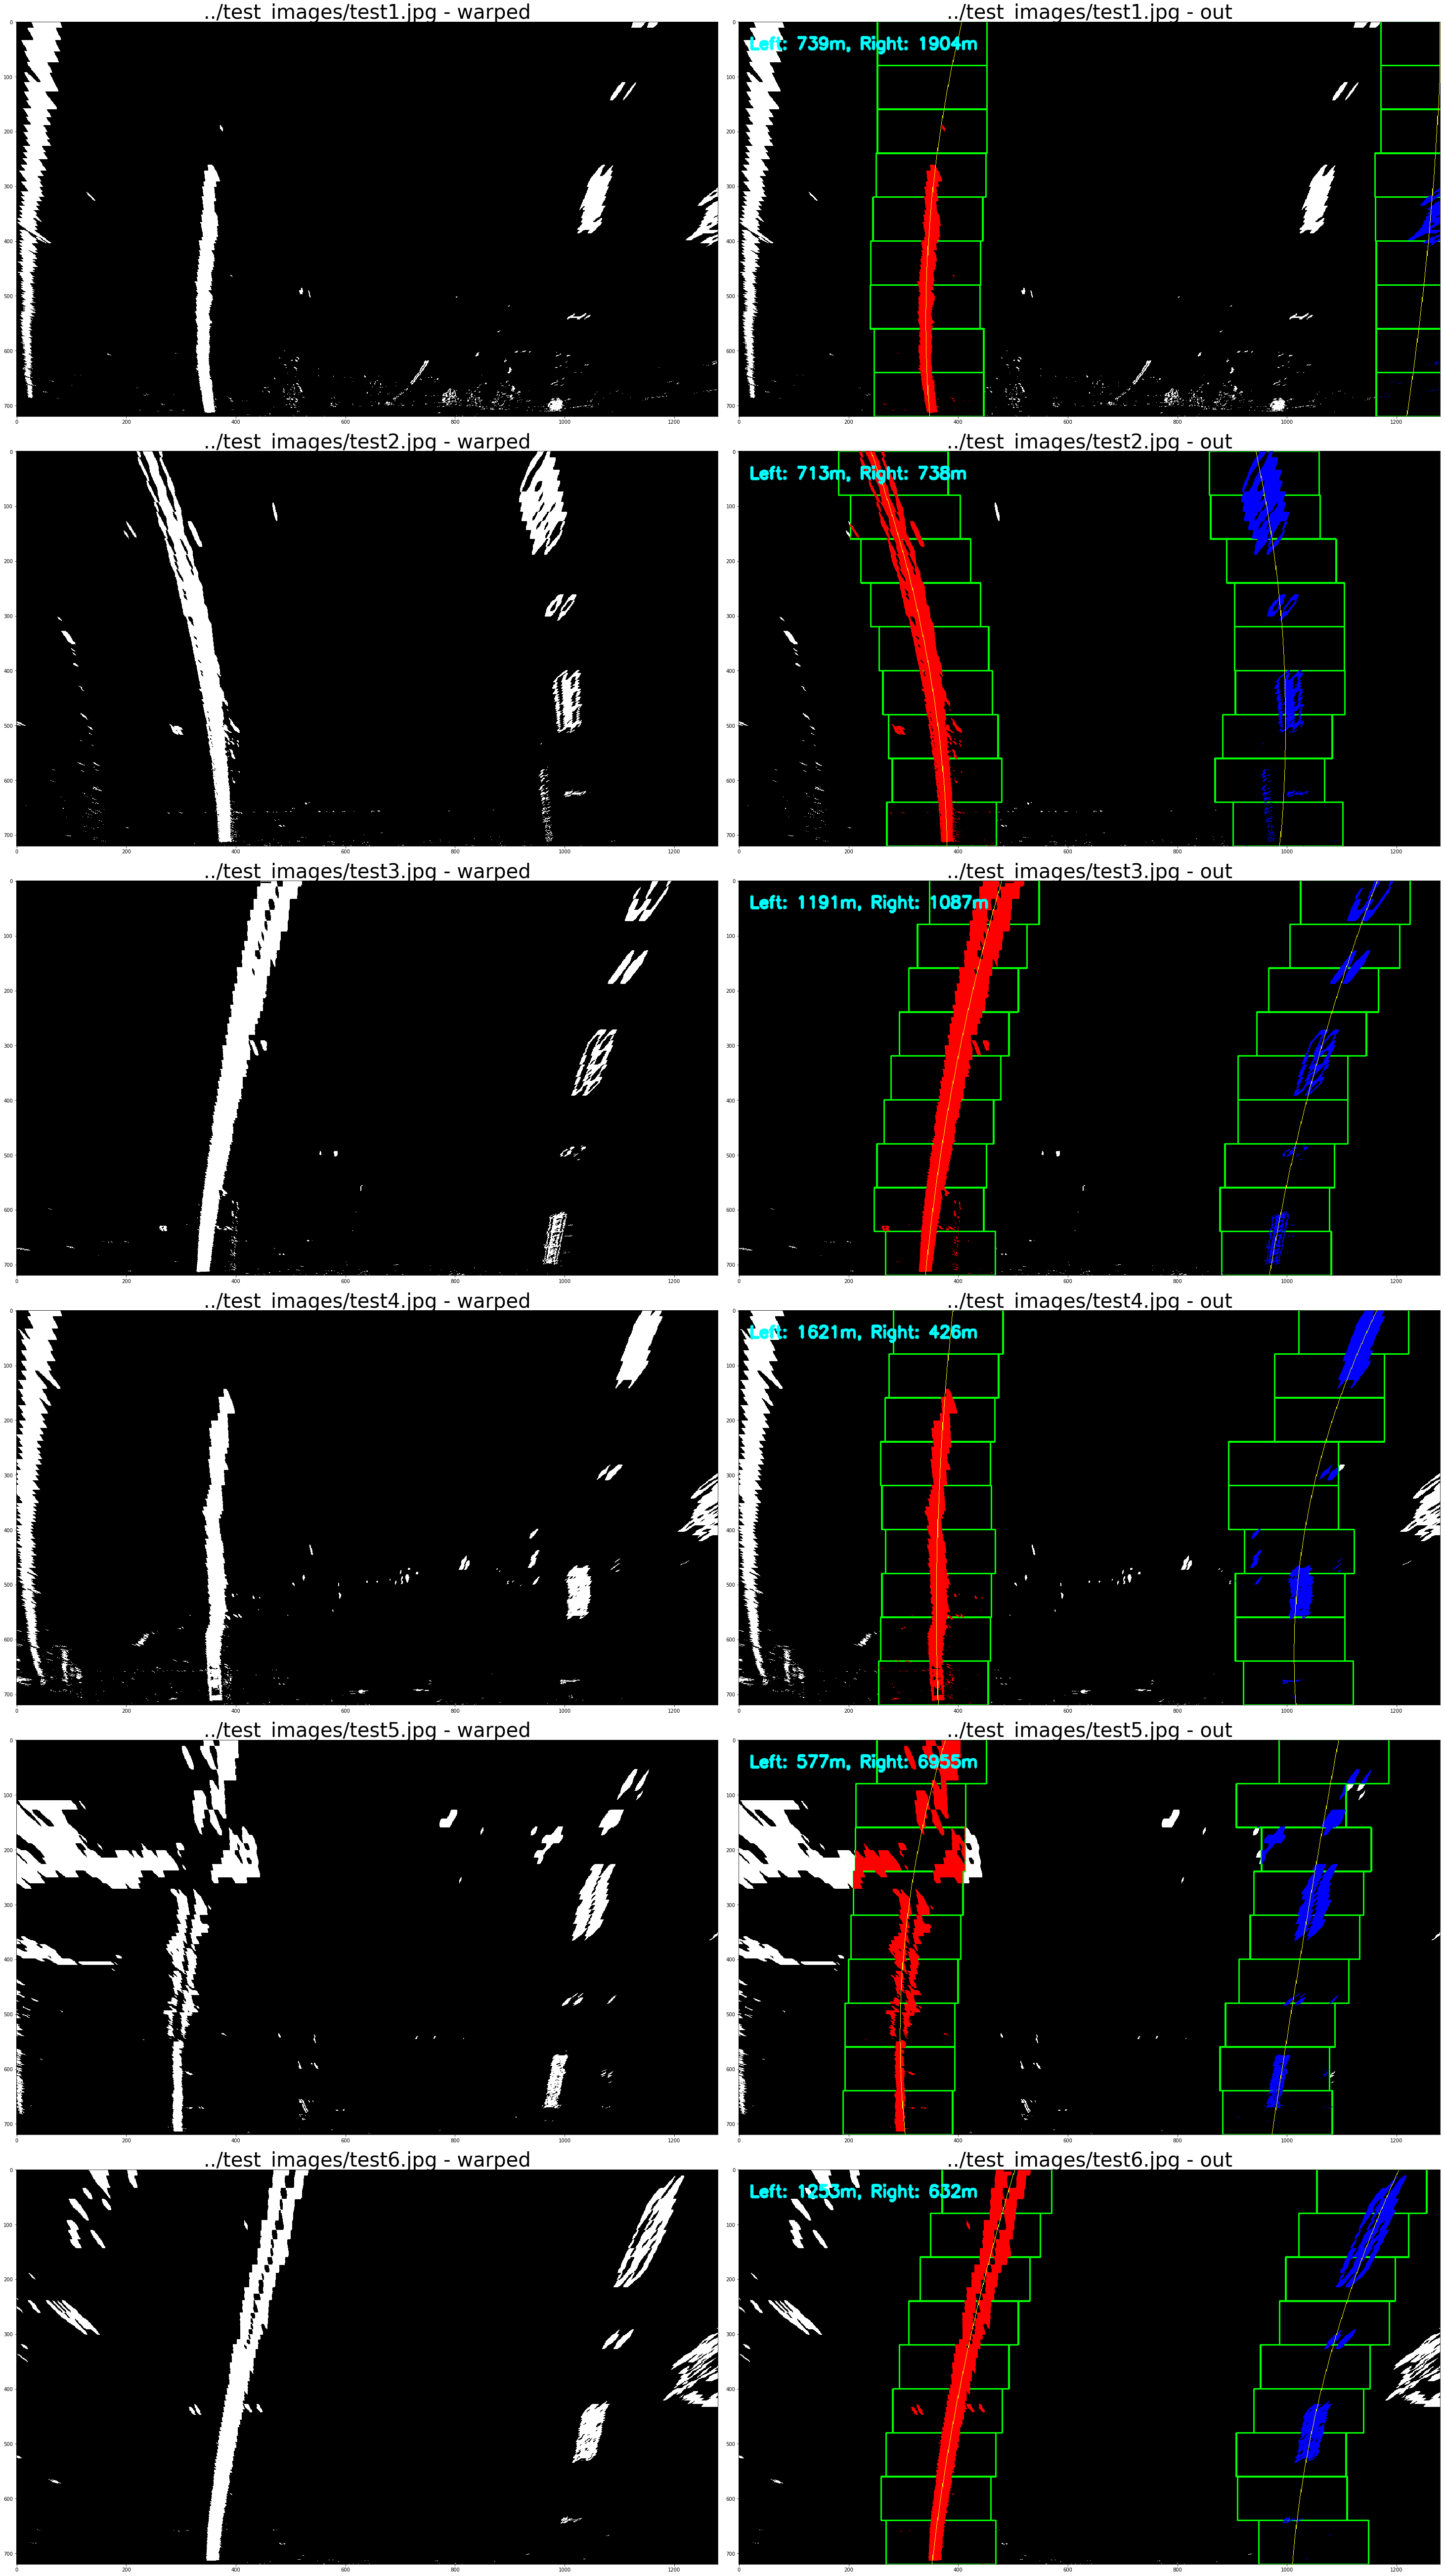

In [11]:
# Make a list of test images
images = glob.glob('../test_images/test*.jpg')

f, axs = plt.subplots(len(images), 2, figsize=(40, 80))
f.tight_layout()

# Step through the list and search for chessboard corners
for index, fname in enumerate(images):
    img = mpimg.imread(fname)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    color_binary, combined_binary = get_binary(undistorted)
    warped = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)
    out = find_lane_lines(warped)
  
    axs.flat[index*2].imshow(warped, cmap="gray")
    axs.flat[index*2].set_title('{} - warped'.format(fname), fontsize=40)
    axs.flat[index*2+1].imshow(out)
    axs.flat[index*2+1].set_title('{} - out'.format(fname), fontsize=40)
    
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Pipeline video

In [57]:
nwindows = 9
window_width = 50 
margin = 100 # How much to slide left and right for searching

def draw_lane_lines(undistorted, binary_warped):
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    # Set height of windows
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted.shape[1], undistorted.shape[0])) 

    # Measure curvature
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Center 
    center_x = (((left_fitx[719] + right_fitx[719]) / 2) - 640) * xm_per_pix * 100
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.rectangle(newwarp, (10, 10), (1270, 90), (255, 255, 255), thickness=-1)
    cv2.putText(newwarp, "Curve Radius - Left: {:.0f}m, Right: {:.0f}m".format(left_curverad, right_curverad),(20,40), font, 1,(0,0,0),1,cv2.LINE_AA)
    cv2.putText(newwarp, "Center: {:.0f}cm".format(center_x),(20,80), font, 1,(0,0,0),1,cv2.LINE_AA)

    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.5, 0)

    return result

In [58]:
def pipeline(img):
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    color_binary, combined_binary = get_binary(undistorted)
    binary_warped = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)
    out = draw_lane_lines(undistorted, binary_warped)
    return out

In [59]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("../project_video.mp4")
output_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:36<00:00,  7.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 1s, sys: 43.8 s, total: 3min 44s
Wall time: 2min 36s


In [60]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))